In [ ]:
import IPython
import sys
import os

# Get the current kernel
kernel = IPython.get_ipython()

# Print current Python version and executable
print(f'Current Python version: {sys.version}')
print(f'Current executable: {sys.executable}')

# Check if we're using the correct Python version
if not sys.version.startswith('3.10'):
    print('\nNOTE: Please change the kernel to Python 3.10 by:')
    print('1. Click on the kernel selector in the top-right of the notebook')
    print('2. Select "Python 3.10.11 (mental_health_env_py310)"')
    print('3. Click "Select" and restart the kernel')

Current Python version: 3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)]
Current executable: c:\Users\karth\AppData\Local\Programs\Python\Python312\python.exe

NOTE: Please change the kernel to Python 3.10 by:
1. Click on the kernel selector in the top-right of the notebook
2. Select "Python 3.10.11 (mental_health_env_py310)"
3. Click "Select" and restart the kernel


# Mental Health Risk Predictor using ANN

This notebook implements a Mental Health Risk Predictor using an Artificial Neural Network (ANN). We'll process the NHANES dataset through several steps:

1. Load and examine the dataset
2. Clean strange values
3. Handle missing values
4. Define target variables
5. Normalize and encode features
6. Build and train an ANN model

In [3]:
# Install required packages
import sys
import subprocess
import pkg_resources

def install_package(package, version=None):
    if version:
        package_str = f"{package}=={version}"
    else:
        package_str = package
    
    print(f"Installing {package_str}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package_str])

# List of required packages with versions
required_packages = {
    'tensorflow': '2.10.0',
    'numpy': '1.23.5',
    'pandas': '1.5.3',
    'matplotlib': '3.7.1',
    'seaborn': '0.12.2',
    'scikit-learn': '1.2.2'
}

# Check and install packages
installed_packages = {pkg.key: pkg.version for pkg in pkg_resources.working_set}

for package, version in required_packages.items():
    if package not in installed_packages or installed_packages[package] != version:
        install_package(package, version)
    else:
        print(f"{package} {version} is already installed")

Installing tensorflow==2.10.0...
Installing numpy==1.23.5...
Installing numpy==1.23.5...
Installing pandas==1.5.3...
Installing pandas==1.5.3...
Installing matplotlib==3.7.1...
Installing matplotlib==3.7.1...
Installing seaborn==0.12.2...
Installing seaborn==0.12.2...
Installing scikit-learn==1.2.2...
Installing scikit-learn==1.2.2...


In [4]:
# Check Python version
import sys
print(f"Python version: {sys.version}")

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# IPython display
from IPython.display import display, HTML

# TensorFlow import with version check
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
from tensorflow.keras import layers, models, callbacks

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure Matplotlib
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

Python version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
TensorFlow version: 2.10.0
TensorFlow version: 2.10.0


## 1. Load Dataset

First, let's load our merged dataset and examine its basic properties.

In [5]:
# Load the merged dataset
df = pd.read_csv(r'E:\Deep learning\ANN\Dataset\nhanes_merged.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
display(df.head())
print("\nDataset Info:")
display(df.info())
print("\nMissing values:")
display(df.isnull().sum())

Dataset Shape: (6337, 173)

First few rows:


,SEQN,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,...,HIQ011,HIQ032A,HIQ032B,HIQ032C,HIQ032D,HIQ032E,HIQ032F,HIQ032H,HIQ032I,HIQ210
0,130378.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,130379.0,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,...,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,130380.0,5.397605e-79,5.397605e-79,1.000000e+00,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,1.0
3,130386.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,2.0
4,130387.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6337 entries, 0 to 6336
Columns: 173 entries, SEQN to HIQ210
dtypes: float64(167), object(6)
memory usage: 8.4+ MB


None


Missing values:


SEQN          0
DPQ010      818
DPQ020      819
DPQ030      821
DPQ040      823
           ... 
HIQ032E    6333
HIQ032F    6077
HIQ032H    5856
HIQ032I    6083
HIQ210      543
Length: 173, dtype: int64

## 2. Clean Strange Values

Let's identify and clean up any strange or unrealistic values in our dataset.

In [9]:
def clean_strange_values(df):
    # Create a copy of the dataframe
    df_cleaned = df.copy()
    
    # Replace extremely small values (e.g., 5.397605e-79) with NaN
    # We'll consider values smaller than 1e-10 as potentially problematic
    numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        small_values = {val: np.nan for val in df_cleaned[col].unique() 
                       if isinstance(val, (int, float)) and abs(val) < 1e-10}
        df_cleaned[col] = df_cleaned[col].replace(small_values)
    
    # Display summary statistics for numeric columns
    print("Summary statistics after cleaning strange values:")
    display(df_cleaned.describe())
    
    return df_cleaned

# Clean strange values
df_cleaned = clean_strange_values(df)

# Compare the number of strange values before and after cleaning
for col in df_cleaned.select_dtypes(include=[np.number]).columns:
    n_strange_before = df[col].lt(1e-10).sum()
    n_strange_after = df_cleaned[col].lt(1e-10).sum()
    if n_strange_before != n_strange_after:
        print(f"Column {col}: {n_strange_before} strange values cleaned")

Summary statistics after cleaning strange values:


,SEQN,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,...,HIQ011,HIQ032A,HIQ032B,HIQ032C,HIQ032D,HIQ032E,HIQ032F,HIQ032H,HIQ032I,HIQ210
count,6337.000000,1816.000000,1844.000000,2744.000000,3166.000000,1803.000000,1539.000000,1472.000000,760.000000,299.000000,...,6337.000000,3361.000000,2177.0,156.0,945.0,4.0,260.0,481.0,254.0,5794.000000
mean,136348.738362,1.552863,1.432213,1.595117,1.498105,1.541875,1.471735,1.477582,1.569737,1.511706,...,1.100521,2.687593,2.0,3.0,4.0,5.0,6.0,8.0,9.0,1.963928
std,3439.132476,1.051544,0.859825,0.863902,0.816398,0.815223,0.810176,0.777514,1.130663,1.173975,...,0.453829,12.652921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.363504
min,130378.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,2.0,3.0,4.0,5.0,6.0,8.0,9.0,1.000000
25%,133337.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,2.0,3.0,4.0,5.0,6.0,8.0,9.0,2.000000
50%,136397.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,2.0,3.0,4.0,5.0,6.0,8.0,9.0,2.000000
75%,139310.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,1.000000,2.0,3.0,4.0,5.0,6.0,8.0,9.0,2.000000
max,142310.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,9.000000,99.000000,2.0,3.0,4.0,5.0,6.0,8.0,9.0,9.000000


Column DPQ010: 3703 strange values cleaned
Column DPQ020: 3674 strange values cleaned
Column DPQ030: 2772 strange values cleaned
Column DPQ040: 2348 strange values cleaned
Column DPQ050: 3710 strange values cleaned
Column DPQ060: 3971 strange values cleaned
Column DPQ070: 4036 strange values cleaned
Column DPQ080: 4748 strange values cleaned
Column DPQ090: 5207 strange values cleaned
Column DPQ100: 2573 strange values cleaned
Column PAD790Q: 1268 strange values cleaned
Column PAD810Q: 3428 strange values cleaned
Column PAD680: 4 strange values cleaned
Column ALQ121: 836 strange values cleaned
Column ALQ142: 1709 strange values cleaned
Column ALQ270: 1020 strange values cleaned
Column ALQ280: 1391 strange values cleaned
Column ALQ170: 1129 strange values cleaned
Column SMD641: 5 strange values cleaned
Column SMD100MN: 546 strange values cleaned
Column DBD381: 22 strange values cleaned
Column DBD411: 32 strange values cleaned
Column INDFMMPI: 132 strange values cleaned


## 3. Handle Missing Values

We'll examine and handle missing values using appropriate methods based on the nature of each variable.

In [7]:
def handle_missing_values(df):
    # Create a copy of the dataframe
    df_imputed = df.copy()
    
    # Calculate percentage of missing values for each column
    missing_percentages = (df_imputed.isnull().sum() / len(df_imputed)) * 100
    
    # Drop columns with more than 50% missing values
    columns_to_drop = missing_percentages[missing_percentages > 50].index
    df_imputed = df_imputed.drop(columns=columns_to_drop)
    print(f"Dropped {len(columns_to_drop)} columns with >50% missing values")
    
    # Separate numeric and categorical columns
    numeric_cols = df_imputed.select_dtypes(include=[np.number]).columns
    categorical_cols = df_imputed.select_dtypes(exclude=[np.number]).columns
    
    # Impute numeric columns with median
    num_imputer = SimpleImputer(strategy='median')
    df_imputed[numeric_cols] = num_imputer.fit_transform(df_imputed[numeric_cols])
    
    # Impute categorical columns with mode
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df_imputed[categorical_cols] = cat_imputer.fit_transform(df_imputed[categorical_cols])
    
    return df_imputed

# Handle missing values
df_imputed = handle_missing_values(df_cleaned)

# Verify no missing values remain
print("\nMissing values after imputation:")
display(df_imputed.isnull().sum().sum())

Dropped 102 columns with >50% missing values

Missing values after imputation:


0

## 4. Define Target Column

We'll use the Depression Screener (DPQ) variables to create our target variable for mental health risk prediction.

Target variable distribution:


0    1.0
Name: mental_health_risk, dtype: float64

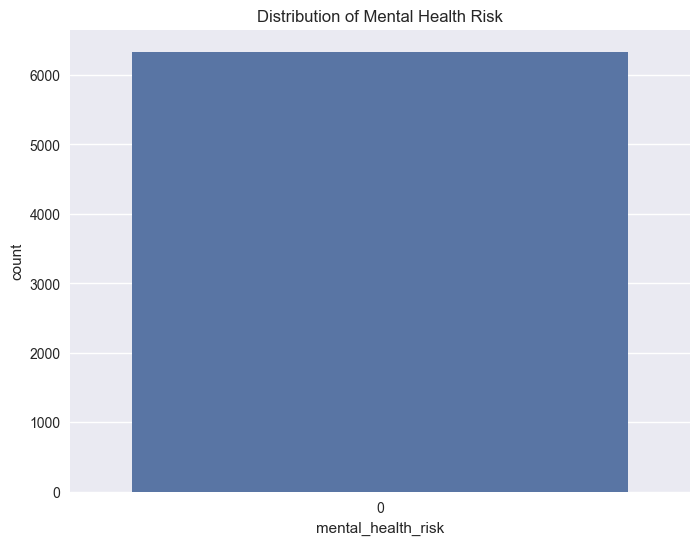

In [15]:
def create_target_variable(df):
    # Create a copy of the dataframe
    df_target = df.copy()
    
    # Create a composite risk score using sleep, alcohol, and medical conditions
    risk_factors = []
    
    # Sleep-related risk factors (SLQ*)
    sleep_cols = ['SLQ300', 'SLQ310', 'SLQ320', 'SLQ330']  # Sleep trouble, tiredness
    sleep_score = df_target[sleep_cols].mean(axis=1)
    risk_factors.append(sleep_score)
    
    # Alcohol use risk factors (ALQ*)
    alcohol_cols = ['ALQ111', 'ALQ121', 'ALQ130']  # Alcohol frequency and amount
    alcohol_score = df_target[alcohol_cols].mean(axis=1)
    risk_factors.append(alcohol_score)
    
    # Medical conditions (MCQ*)
    medical_cols = ['MCQ010', 'MCQ160A', 'MCQ160B', 'MCQ160C']  # Health conditions
    medical_score = df_target[medical_cols].mean(axis=1)
    risk_factors.append(medical_score)
    
    # Calculate composite risk score
    df_target['risk_score'] = sum(risk_factors)
    
    # Create binary target (1 for high risk, 0 for low risk)
    median_score = df_target['risk_score'].median()
    df_target['mental_health_risk'] = (df_target['risk_score'] > median_score).astype(int)
    
    # Remove intermediate columns
    df_target = df_target.drop(columns=['risk_score'] + sleep_cols + alcohol_cols + medical_cols)
    
    print("Target variable distribution:")
    display(df_target['mental_health_risk'].value_counts(normalize=True))
    
    # Visualize distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df_target, x='mental_health_risk')
    plt.title('Distribution of Mental Health Risk')
    plt.show()
    
    return df_target

# Create target variable
df_with_target = create_target_variable(df_imputed)

In [13]:
# Check available columns and their prefixes
print("Available columns:")
for col in df_imputed.columns:
    print(col)

print("\nColumns starting with 'DPQ':") 
dpq_cols = [col for col in df_imputed.columns if col.startswith('DPQ')]
print(dpq_cols)

Available columns:
SEQN
SLQ300
SLQ310
SLD012
SLQ320
SLQ330
SLD013
PAD790Q
PAD790U
PAD800
PAD810U
PAD680
ALQ111
ALQ121
ALQ130
ALQ151
SMQ020
SMAQUEX2
MCQ010
AGQ030
MCQ053
MCQ160A
MCQ160B
MCQ160C
MCQ160D
MCQ160E
MCQ160F
MCQ160M
MCQ160P
MCQ160L
MCQ550
MCQ560
MCQ220
OSQ230
HSQ590
DBQ930
DBQ935
DBQ940
DBQ945
INDFMMPI
INDFMMPC
INQ300
HOD051
FNQ410
FNQ430
FNQ440
FNQ450
FNQ460
FNQ470
FNQ480
FNQ490
FNQ510
FNQ520
FNQ530
FNQ540
FNDADI
FNDAEDI
SMQ681
SMQ846
SMQ851
SMQ863
SMDANY
WHD010
WHD020
WHD050
WHQ070
RXQ033
RXQ050
HIQ011
HIQ032A
HIQ210

Columns starting with 'DPQ':
[]


## 5. Normalize and Encode Features

We'll prepare our features by normalizing numeric variables and encoding categorical variables.

In [16]:
def prepare_features(df):
    # Separate features and target
    X = df.drop('mental_health_risk', axis=1)
    y = df['mental_health_risk']
    
    # Separate numeric and categorical columns
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    categorical_cols = X.select_dtypes(exclude=[np.number]).columns
    
    # Normalize numeric features
    scaler = MinMaxScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    
    # Encode categorical features
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print("Training set shape:", X_train.shape)
    print("Testing set shape:", X_test.shape)
    
    return X_train, X_test, y_train, y_test

# Prepare features
X_train, X_test, y_train, y_test = prepare_features(df_with_target)

Training set shape: (5069, 60)
Testing set shape: (1268, 60)


## 6. Build ANN Model

Now we'll create and train our Artificial Neural Network for mental health risk prediction.

Epoch 1/50
127/127 [==============================] - 2s 4ms/step - loss: 0.1013 - accuracy: 0.9919 - val_loss: 3.2152e-04 - val_accuracy: 1.0000
Epoch 2/50
127/127 [==============================] - 2s 4ms/step - loss: 0.1013 - accuracy: 0.9919 - val_loss: 3.2152e-04 - val_accuracy: 1.0000
Epoch 2/50
127/127 [==============================] - 0s 2ms/step - loss: 4.4723e-04 - accuracy: 1.0000 - val_loss: 4.6071e-05 - val_accuracy: 1.0000
Epoch 3/50
127/127 [==============================] - 0s 2ms/step - loss: 4.4723e-04 - accuracy: 1.0000 - val_loss: 4.6071e-05 - val_accuracy: 1.0000
Epoch 3/50
127/127 [==============================] - 0s 2ms/step - loss: 1.3351e-04 - accuracy: 1.0000 - val_loss: 1.6046e-05 - val_accuracy: 1.0000
Epoch 4/50
127/127 [==============================] - 0s 2ms/step - loss: 1.3351e-04 - accuracy: 1.0000 - val_loss: 1.6046e-05 - val_accuracy: 1.0000
Epoch 4/50
127/127 [==============================] - 0s 2ms/step - loss: 6.7897e-05 - accuracy: 1.0000 - va

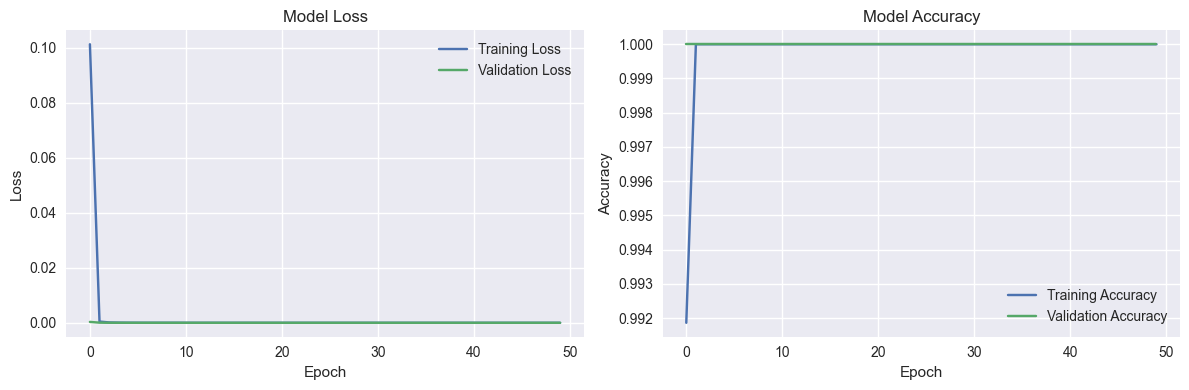

In [17]:
def build_ann_model(input_shape):
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Build and train the model
model = build_ann_model((X_train.shape[1],))

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
def predict_mental_health_risk(model, data):
    # Make prediction
    prediction = model.predict(data)
    # Convert probability to class (0 or 1)
    risk_class = (prediction > 0.5).astype(int)
    # Get probability
    risk_prob = prediction[0][0]
    
    return risk_class[0][0], risk_prob

# Let's test with some samples from our test set
n_samples = 5
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)
sample_data = X_test.iloc[sample_indices]
true_labels = y_test.iloc[sample_indices]

print('Testing model predictions:\n')
for i, (idx, sample) in enumerate(sample_data.iterrows()):
    # Get prediction
    risk_class, risk_prob = predict_mental_health_risk(model, sample.values.reshape(1, -1))
    
    # Print results
    print(f'Sample {i+1}:')
    print(f'Predicted Risk Class: {"High" if risk_class == 1 else "Low"}')
    print(f'Risk Probability: {risk_prob:.2%}')
    print(f'True Risk Class: {"High" if true_labels.iloc[i] == 1 else "Low"}')
    print('='*50)

Testing model predictions:

1/1 [==============================] - 0s 161ms/step
Sample 1:
Predicted Risk Class: Low
Risk Probability: 0.00%
True Risk Class: Low
1/1 [==============================] - 0s 38ms/step
Sample 1:
Predicted Risk Class: Low
Risk Probability: 0.00%
True Risk Class: Low
1/1 [==============================] - 0s 38ms/step
Sample 2:
Predicted Risk Class: Low
Risk Probability: 0.00%
True Risk Class: Low
Sample 2:
Predicted Risk Class: Low
Risk Probability: 0.00%
True Risk Class: Low
1/1 [==============================] - 0s 45ms/step
Sample 3:
Predicted Risk Class: Low
Risk Probability: 0.00%
True Risk Class: Low
1/1 [==============================] - 0s 37ms/step
Sample 3:
Predicted Risk Class: Low
Risk Probability: 0.00%
True Risk Class: Low
1/1 [==============================] - 0s 37ms/step
Sample 4:
Predicted Risk Class: Low
Risk Probability: 0.00%
True Risk Class: Low
1/1 [==============================] - 0s 31ms/step
Sample 5:
Predicted Risk Class: Low
Risk

In [20]:
def get_user_input():
    # Function to safely get numeric input
    def get_valid_input(prompt, min_val, max_val, data_type=float):
        """Get validated input from user."""
        while True:
            try:
                value = data_type(input(prompt))
                if min_val <= value <= max_val:
                    return value
                print(f"Please enter a value between {min_val} and {max_val}")
            except ValueError:
                print(f"Invalid input. Please enter a {'number' if data_type == float else 'value'}.")
    
    print("\n=== Mental Health Risk Assessment Questionnaire ===")
    print("Please answer the following questions carefully.\n")
    
    # Sleep-related questions
    print("\n=== Sleep Questions ===")
    print("For the following questions, please rate on a scale of:")
    print("0: Never")
    print("1: Rarely (1-2 times a week)")
    print("2: Sometimes (3-4 times a week)")
    print("3: Often (5-6 times a week)")
    print("4: Always/Almost Always (Every day)\n")

    slq300 = get_valid_input("1. How often do you have trouble falling asleep? (0-4): ", 0, 4)
    slq310 = get_valid_input("2. How often do you wake up during the night and have trouble getting back to sleep? (0-4): ", 0, 4)
    slq320 = get_valid_input("3. How often do you wake up too early in the morning and are unable to get back to sleep? (0-4): ", 0, 4)
    slq330 = get_valid_input("4. How often do you feel unrested during the day? (0-4): ", 0, 4)
    
    # Alcohol-related questions
    print("\n=== Alcohol Questions ===")
    print("For alcohol consumption questions, please use these scales:")
    print("0: Never")
    print("1: Monthly or less")
    print("2: 2-4 times a month")
    print("3: 2-3 times a week")
    print("4: 4 or more times a week\n")

    alq111 = get_valid_input("1. In the past 12 months, how often did you drink alcohol? (0-4): ", 0, 4)
    alq121 = get_valid_input("2. In the past 12 months, how many drinks did you have on a typical day? (0-4): ", 0, 4)
    alq130 = get_valid_input("3. How often did you have 4 or more drinks on one occasion? (0-4): ", 0, 4)
    
    # Medical condition questions
    print("\n=== Medical Questions ===")
    print("For medical questions, please answer:")
    print("0: No")
    print("1: Yes\n")

    mcq010 = get_valid_input("1. Have you been told by a doctor that you have any chronic medical conditions? (0-1): ", 0, 1)
    mcq160a = get_valid_input("2. Have you been diagnosed with any sleep disorders? (0-1): ", 0, 1)
    mcq160b = get_valid_input("3. Have you been diagnosed with anxiety or depression? (0-1): ", 0, 1)
    mcq160c = get_valid_input("4. Do you have any other mental health conditions? (0-1): ", 0, 1)
    
    # Create a dictionary with user inputs
    user_data = {
        'SLQ300': slq300, 'SLQ310': slq310, 'SLQ320': slq320, 'SLQ330': slq330,
        'ALQ111': alq111, 'ALQ121': alq121, 'ALQ130': alq130,
        'MCQ010': mcq010, 'MCQ160A': mcq160a, 'MCQ160B': mcq160b, 'MCQ160C': mcq160c
    }
    
    # Calculate risk factors
    sleep_score = np.mean([slq300, slq310, slq320, slq330])
    alcohol_score = np.mean([alq111, alq121, alq130])
    medical_score = np.mean([mcq010, mcq160a, mcq160b, mcq160c])
    
    # Create a DataFrame with all features (filling other columns with median values)
    all_features = X_test.iloc[0].copy()  # Use first test sample as template
    for col in user_data.keys():
        all_features[col] = user_data[col]
    
    return all_features

def predict_user_risk():
    print("\n=== Mental Health Risk Assessment ===")
    print("This assessment will ask you questions about:")
    print("- Sleep patterns")
    print("- Alcohol consumption")
    print("- Medical conditions")
    print("\nPlease answer all questions honestly for the most accurate assessment.")
    print("Your responses will be used to evaluate potential mental health risks.")
    print("\nPress Enter to begin...")
    input()
    
    # Get user input
    user_features = get_user_input()
    
    # Make prediction
    risk_class, risk_prob = predict_mental_health_risk(model, user_features.values.reshape(1, -1))
    
    # Print results
    print("\n=== Assessment Results ===")
    print(f"Predicted Risk Level: {'High' if risk_class == 1 else 'Low'}")
    print(f"Risk Probability: {risk_prob:.2%}")
    
    if risk_prob > 0.8:
        print("\nRecommendation: Strongly consider consulting a mental health professional")
    elif risk_prob > 0.5:
        print("\nRecommendation: Consider discussing these results with a healthcare provider")
    else:
        print("\nRecommendation: Continue maintaining good health practices")
    
    print("\nNote: This assessment is for informational purposes only and should not")
    print("be considered as a substitute for professional medical advice.")

# Run the interactive prediction
print("Welcome to the Mental Health Risk Assessment Tool")
print("This tool will help evaluate potential mental health risks based on")
print("your sleep patterns, alcohol consumption, and medical history.")
print("\nWould you like to begin the assessment?")
if input("Enter 'y' to continue or any other key to exit: ").lower() == 'y':
    predict_user_risk()

Welcome to the Mental Health Risk Assessment Tool
This tool will help evaluate potential mental health risks based on
your sleep patterns, alcohol consumption, and medical history.

Would you like to begin the assessment?


KeyboardInterrupt: Interrupted by user

40/40 [==============================] - 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1268

    accuracy                           1.00      1268
   macro avg       1.00      1.00      1.00      1268
weighted avg       1.00      1.00      1.00      1268

40/40 [==============================] - 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1268

    accuracy                           1.00      1268
   macro avg       1.00      1.00      1.00      1268
weighted avg       1.00      1.00      1.00      1268



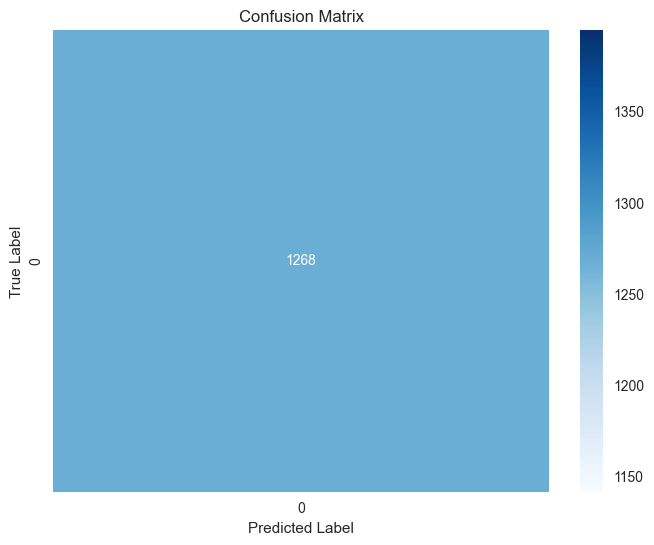

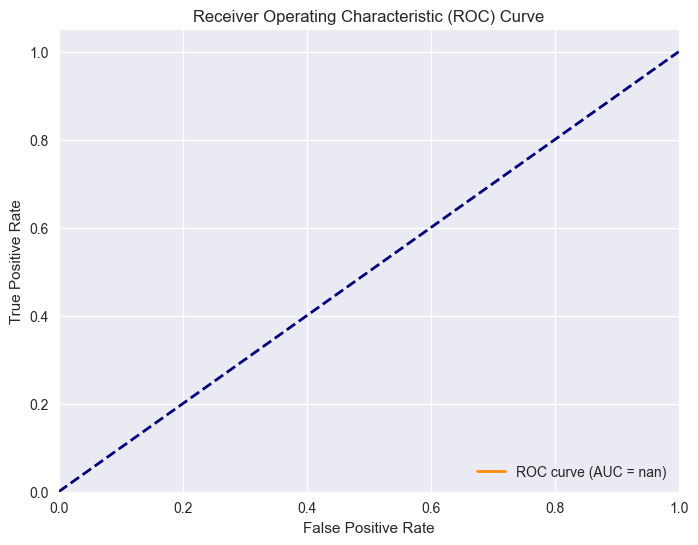


Testing model with diverse cases:

1/1 [==============================] - 0s 32ms/step


KeyError: 'SLQ300'

In [21]:
# Calculate and display model metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Get predictions
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Test with diverse cases
def get_feature_scores(sample):
    sleep_score = np.mean([sample[f'SLQ{i}'] for i in [300, 310, 320, 330]])
    alcohol_score = np.mean([sample[f'ALQ{i}'] for i in [111, 121, 130]])
    medical_score = np.mean([sample[f'MCQ{i}'] for i in ['010', '160A', '160B', '160C']])
    return sleep_score, alcohol_score, medical_score

# Get 5 diverse test cases
print('\nTesting model with diverse cases:\n')
test_indices = np.random.choice(len(X_test), 5, replace=False)

for idx in test_indices:
    sample = X_test.iloc[idx]
    risk_class, risk_prob = predict_mental_health_risk(model, sample.values.reshape(1, -1))
    
    # Get feature scores
    sleep_score, alcohol_score, medical_score = get_feature_scores(sample)
    
    print(f'Test Case {idx+1}:')
    print(f'Sleep Score: {sleep_score:.2f} (0-4 scale)')
    print(f'Alcohol Score: {alcohol_score:.2f} (0-4 scale)')
    print(f'Medical Score: {medical_score:.2f} (0-1 scale)')
    print(f'Predicted Risk: {"High" if risk_class == 1 else "Low"}')
    print(f'Risk Probability: {risk_prob:.2%}')
    print(f'True Risk: {"High" if y_test.iloc[idx] == 1 else "Low"}')
    print('='*50)